# The present notebook contains code for the computation of the intersection volume between simplices in d-dimensions
The method coded in this notebook is based o a number of theoretical results from affine spaces and convex geometry that can be found in the pdf file *Theoretical_Framework* (uploaded in the same branch where the present notebook is found) 

---
# INTERSECTION BETWEEN SIMPLICES
---
## A few theoretical remarks
$p_1,\cdots,p_d\in\mathbb R^n$ are said to be ***affinely independent*** if the equalities:

$$ \alpha_1 p_1 +\cdots \alpha_d p_d = 0\\
\alpha_1+\cdots + \alpha_d=0$$

are true only for $\alpha_1 = \cdots = \alpha_d = 0$.

**Barycentric coordinates**: The barycentric coordinates of a point $q\in\mathbb R^n$ in terms of $n+1$ affinely independent points: $p_0,\cdots,p_n$ are the (unique) values $\beta_0,\cdots,\beta_n$ for which it holds

$$ q = \beta_0 p_0+\cdots+\beta_n p_n\\
   \beta_0 + \cdots+\beta_n = 1$$
   
**Polytope**: The (convex) polytope generated by the points $p_1,\cdots,p_m$ (not necessarily affinely independent) is the set of all points of the form

$$ \beta_1 p_1+\cdots + \beta_m p_m\,,\qquad {\rm with} \qquad \beta_1+\cdots+\beta_m = 1 \qquad {\rm and} \qquad \beta_i \geq 0, \, i= 1,\cdots,m$$

**Simplex**: An n-dimensional simplex is a polytope generate by n+1 affinely independent points (vertices) in $\mathbb R^n$.

**Triangulation**: A triangulation for a (convex) polytope, $P$, is a set of simplices $\left\{ S_1,\cdots,S_m\right\}$ that verifies:

$$ \begin{array}{l}
\cup_{i=1}^m S_i = P\\
 S_i\cap S_j \,\textrm{is either empty or a common boundary}\end{array}$$

---
# Importing libraries and modules

In [1]:
import numpy as np
import scipy.linalg as lg 
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay 
from itertools import permutations 

---
## MAIN INTERSECTION FUNCTION
This function computes the volume of intersection between two arbitrary simplices in d-dimensions.

* **Argument**: a tuple of two numpy arrays of shape (d+1,d), containing the vertices generating the simplices
---
* **Outcome**  a tuple (intersect_vol , intersect_points):
    * intersect_vol : float 
               The intersection volume
    * intersect_points : numpy array of shape (n,d). 
               The set of vertices generating the intersecting polytope  

In [2]:
def simplex_intersection(vertices):
    """
    Identifies the vertices of the polytope formed by the intersection 
    of two simplices and its volume
    
    Args:
        
        vertices : tuple  (vertices1, vertices2)  
                   
                   vertices1: (d+1,d) numpy array. 
                   Each row contains the components of a vertex of the simplex 1
                   vertices2 : (d+1,d) numpy array. 
                   Each row contains the components of a vertex of the simplex 2
        
    returns:
        
        intersect_vol : float. The volume of the intersecting politope
        
        intersect_points : (k,d) numpy array. Each row contains the components of a vertex of 
                                               the intersecting polytope
    """
    min_vol = 10**(-8) # mimimum intersection volume considered   
    det_tol = 10**(-10)  # tolerance to handle the determinants
    
    vertices1, vertices2 = vertices 
    d = vertices1.shape[1]
    
    """
    Computing the signed volume (orientation) generated by the vertices
    """
    
    sign_vol1 = lg.det(np.append(np.ones((d+1,1)) , vertices1, axis = 1))
    sign_vol2 = lg.det(np.append(np.ones((d+1,1)) , vertices2, axis = 1))
    
    vols = (np.abs(sign_vol1) , np.abs(sign_vol2))
    
    intersect_vol = 0 
    intersect_points = [] 
    
    
    if min(vols) > min_vol:
        # Only compute if the intersection volume is big enough
    
        """
        Centroids of the simplices
        """
    
        cent1 = vertices1.mean(axis=0)
        cent2 = vertices2.mean(axis=0)
    
        """
        Radius of the circumsphere of each simplex
        """
    
        rad1 = np.sqrt(((vertices1-cent1)**2).sum(axis=1).max())
        rad2 = np.sqrt(((vertices2-cent2)**2).sum(axis=1).max()) 
    
        """
        Intersecting circumspheres
        """
       
        if ((cent1-cent2)**2).sum() - (rad1+rad2)**2 < 0:
            # The circumspheres do intersect 
            n1in2 = points_in_sphere(vertices1,cent2,rad2)
            n2in1 = points_in_sphere(vertices2,cent1,rad1)
            if n1in2 + n2in1 >= 1:
                # At least one circumsphere contains vertices of the other simplex
               
                """
                Barycentric coordinates of the vertices of one simplex in terms of 
                the vertices of the other
                """
               
                bar_coord, vertices_info = barycentric_simp(vertices1,vertices2,
                                                                  sign_vol1,sign_vol2)
               
                bar_coord_1in2, bar_coord_2in1 = bar_coord 
                vert_1in2, vert_2in1, shared_vertices_in1 , shared_vertices_in2 = vertices_info 
               
                n1in2 = vert_1in2.sum()
                n2in1 = vert_2in1.sum()
               
                if (n1in2 == d+1) | (n2in1 == d+1):
                   ## one simplex contained in the other
                    which_simpl_is_contained = np.argmin(vols) 
                    intersect_vol = vols[which_simpl_is_contained]
                    intersect_points = vertices[which_simpl_is_contained]
                else:
                   ## No simplex is contained in the other 
                   
                    if shared_vertices_in1.sum() == d:
                       # The simplices share a face 
                       intersect_vol, intersect_points = sharing_a_face(bar_coord_1in2, 
                                                                          shared_vertices_in1,
                                                                          shared_vertices_in2, 
                                                                          vertices2)
                    else:
                        # No face is shared
                       
                        intersect_points , int_points_bar_coord = intersecting_boundaries(vertices, 
                                                                                         bar_coord, 
                                                                                         vertices_info)
                       
                        """
                        Deciding if the simplices intersect in a d-volume
                        """
                       
                        d_volume_int = False
                        if int_points_bar_coord[0].size > 0:
                            d_volume_int = min(int_points_bar_coord[0].mean(axis=0).min() , 
                                               int_points_bar_coord[1].mean(axis=0).min()) > 0
                       
                        if d_volume_int:
                            if intersect_points.shape[0] == d+1:
                                # The intersection is a simplex
                                intersect_vol = np.abs(lg.det(np.append(np.ones((d+1,1)), 
                                                                       intersect_points, axis = 1)))
                            else:
                                # The intersection is a more complex polytope
                                triang_of_polyt_faces = polytope_faces_triang(int_points_bar_coord , 
                                                                             bar_coord_1in2)
                                polyt_centroid = intersect_points.mean(axis=0).reshape((1,d))  
                               
                                for indices in triang_of_polyt_faces:
                                    points = np.append(np.ones((d+1,1)),
                                                      np.append(polyt_centroid , 
                                                      intersect_points[indices], axis=0),axis=1)
                                    intersect_vol = intersect_vol + np.abs(lg.det(points)) 
                       
                       
    return intersect_vol , intersect_points 

---
## Useful fuctions for obtaining the vertices generating the intersection polytope
In the following we define useful functions that are called by the above main function. 

### Barycentric coordinates (of a single point)
This function returns the barycentric coordinates of a given point, in terms of the vertices of a given simplex.

In [3]:
def barycentric_point(point,vertices,sign_vol, 
                      tolerance = 10**(-10)):
    """
    Computes the barycentric coordinates of point in terms of vertices 
    
    
    Args:
        point : (d,) numpy array. The components of the point whose barycentric coordinates 
                                  are to be computed
        vertices : (d+1,d) numpy array. Each row contains the components of a vertex
    
        sign_vol : float. Signed volume (orientation) generated by the vertices
        
        tolerance : float. Tolerance for deciding the vanishing or unity of a 
                           barycentric coordinate.
                           Default value: 10**(-10)
        
    Returns:
        beta : (d+1,) numpy array. Contains the barycentric coordinates 
                                        of point in terms of vertices 
                                        (in the order given by vertices)
        
    """
    
    d = len(point)
    beta = np.zeros(d+1) # barycentric coordinates
    vertices_copy = np.copy(vertices) 
    for i in range(d+1):
        vertices_copy[i,:] = point # substitute the i-th column by point
        ## compute the i-th barycentric coordinate 
        b = lg.det(np.append(np.ones((d+1,1)) , vertices_copy , axis = 1)) / sign_vol 
        vertices_copy[i,:] = vertices[i,:] # restore to original array
        if np.abs(b) > tolerance:
           ## Update beta[i] only if b is distant enough from 0    
            if np.abs(1-np.abs(b)) <= tolerance:
                ## set beta[i] to sign(b) if |b| is close enough to 1 
                beta[i] = np.sign(b)
            else:
                beta[i] = b
        
    
    return beta 

### Barycentric coordinates (of the entire simplex)
This function returns the barycentric coordinates of each simplex, in terms of the vertices of the other.

In [4]:
def barycentric_simp(vertices1,vertices2,sign_vol1,sign_vol2):
    """
    Computes the barycentric coordinates of the vertices1 in term of the vertices2 and vice versa
        
    Args:
        vertices1 : (d+1,d) numpy array. Each row contains the coordinates of a vertex
        vertices2 : (d+1,d) numpy array. Each row contains the coordinates of a vertex
        sign_vol1 : float. Signed volume (orientation) generated by vertices1
        sign_vol2 : float. Signed volume (orientation) generated by vertices2
            
    Returns:    
        
        bar_coord : tuple (bar_coord_1in2 , bar_coord_2in1) 
                           
                           bar_coord_1in2 : (d+1,d+1) numpy array. 
                           The i-th row contains the barycentric coordinates 
                           of the i-th point in vertices1 in terms of vertices2
                           (in the order given by vertices2)
                                                
                           bar_coord_2in1 : (d+1,d+1) numpy array. 
                           The i-th row contains the barycentric coordinates 
                           of the i-th point in vertices2 in terms of vertices1
                           (in the order given by vertices1)
                             
        vertices_info : tuple (vert_1in2, vert_2in2, shared_vertices_in1, shared_vertices_in2)
        
                              vert_1in2 : boolean array of size (d+1,). 
                              True if the corresponding vertex in vertices1 is contained 
                              in the convex expansion of vertices2. False, otherwise 
                                            
                              vert_2in1 : boolean array of size (d+1,). 
                              True if the corresponding vertex in vertices2 is contained 
                              in the convex expansion of vertices1. False, otherwise 
                              
                              shared_vertices_in1 : boolean array of size (d+1,).
                              True if the corresponding vertex in vertices1 is also 
                              a vertex in vertices2. False, otherwise
                              
                              shared_vertices_in2 : boolean array of size (d+1,).
                              True if the corresponding vertex in vertices2 is also 
                              a vertex in vertices1. False, otherwise
                              
                              
    """
     
    d = vertices1.shape[1]
    bar_coord_1in2 = np.zeros((d+1,d+1))
    bar_coord_2in1 = np.zeros((d+1,d+1))
     
    """
    Computing barycentric coordinates
    """
     
    for i in range(d+1):
        # i-th vertex of simplex 1
        point = vertices1[i,:]
        bar_coord_1in2[i,:] = barycentric_point(point,vertices2,sign_vol2)
        # i-th vertex of simplex 2
        point = vertices2[i,:]
        bar_coord_2in1[i,:] = barycentric_point(point,vertices1,sign_vol1)
    
    vert_1in2 = bar_coord_1in2.min(axis=1) >= 0
    shared_vertices_in1 = bar_coord_1in2.max(axis=1) == 1
    shared_vertices_in1 = vert_1in2*shared_vertices_in1 != 0
     
    vert_2in1 = bar_coord_2in1.min(axis=1) >= 0
    shared_vertices_in2 = bar_coord_2in1.max(axis=1) == 1
    shared_vertices_in2 = vert_2in1*shared_vertices_in2 != 0
     
    return (bar_coord_1in2, bar_coord_2in1), (vert_1in2, vert_2in1, shared_vertices_in1, shared_vertices_in2) 


### Simplices sharing a face
This function computes the intersecting volume and returns the vertices generating the intersecting polytope, when the two simplices do share a face.

In [5]:
def sharing_a_face(bar_coord_1in2, shared_vertices_in1,
                   shared_vertices_in2, vertices2):
    """
    Computes the volume of intersection of two simplices sharing a face
    (knowing that no simplex is contained in the other)
    
    Args:
        bar_coord_1in2 : (d+1,d+1) numpy array. 
                         The i-th row contains the barycentric coordinates 
                         of the i-th vertex of the simplex 1 in terms of the vertices
                         of the simplex 2 (in the order given by vertices2)
                         
        shared_vertices_in1 : boolean array of size (d+1,).
                              True if the corresponding vertex in vertices1 is also 
                              a vertex in vertices2. False, otherwise
                              
        shared_vertices_in2 : boolean array of size (d+1,).
                              True if the corresponding vertex in vertices2 is also 
                              a vertex in vertices1. False, otherwise
                              
        vertices2 : (d+1,d) numpy array. Each row contains the components of a vertex
                                         of simplex 2
                              
    Returns:    
        intersect_vol : float. Volume of intersection
        
        intersect_vertices : (d+1,d) numpy array.
                             Each row contains the components of a vertex of 
                             the intersecting polytope (in this case a simplex)
                             
                             
    """
    
    d = len(shared_vertices_in1)
    intersect_vol = 0
    intersect_vertices = vertices2[shared_vertices_in2,:]
    
    ## Barycentric coordinates of the non-shared vertex in simplex 1
    bar_coord_non_shared = bar_coord_1in2[np.logical_not(shared_vertices_in1),:].reshape(d)
    
    ## Barycentric coordinate with respect to the non-shared vertex in simplex 2
    extra_bar_coord = bar_coord_non_shared[np.logical_not(shared_vertices_in2)].item()
    
    if extra_bar_coord >0:
        # The simplices intersect non-trivially
        
        positive_bar_coord = bar_coord_non_shared > 0
        
        intersecting_point = bar_coord_non_shared[positive_bar_coord] @ vertices2[positive_bar_coord,:]
        
        convex_normalization = bar_coord_non_shared[positive_bar_coord].sum()
        
        intersecting_point = intersecting_point / convex_normalization
        
        intersect_vertices = np.append(intersect_vertices, intersecting_point.reshape((1,d-1)), axis = 0)
        
        intersect_vol = np.abs(lg.det(np.append(np.ones((d,1)) , intersect_vertices, axis=1))) 
    
    return intersect_vol, intersect_vertices


### Intersection between the boundaries of the simplices
This function oes the following:
    
* Identifies the pairs of boundaries, containing a boundary from each simplex, that intersect in a single point.
* Returns the collection of all such intersecting points. 
    * A theorem guarantees that the intersection between the two simplices is the polytope generated by these points (see *Theoretical_Framework* notes for details) 

In [6]:
def intersecting_boundaries(vertices, bar_coord, vertices_info,
                            tolerance = 10**(-10)):
    """
    Identifies the uniquely intersecting boundaries (in no vertices)
    and returns the intersecting points
    
    Args:
        vertices : tuple (vertices1 , vertices2)
                   
                   vertices1: (d+1,d) numpy array. 
                   Each row contains the components of a vertex of the simplex 1
                   vertices2 : (d+1,d) numpy array. 
                   Each row contains the components of a vertex of the simplex 2
                   
        bar_coord : tuple (bar_coord_1in2 , bar_coord_2in1) 
                           
                           bar_coord_1in2 : (d+1,d+1) numpy array. 
                           The i-th row contains the barycentric coordinates 
                           of the i-th point in vertices1 in terms of vertices2
                           (in the order given by vertices2)
                                                
                           bar_coord_2in1 : (d+1,d+1) numpy array. 
                           The i-th row contains the barycentric coordinates 
                           of the i-th point in vertices2 in terms of vertices1
                           (in the order given by vertices1)
                             
        vertices_info : tuple (vert_1in2, vert_2in2, shared_vertices_in1, shared_vertices_in2)
        
                              vert_1in2 : boolean array of size (d+1,). 
                              True if the corresponding vertex in vertices1 is contained 
                              in the convex expansion of vertices2. False, otherwise 
                                            
                              vert_2in1 : boolean array of size (d+1,). 
                              True if the corresponding vertex in vertices2 is contained 
                              in the convex expansion of vertices1. False, otherwise 
                              
                              shared_vertices_in1 : boolean array of size (d+1,).
                              True if the corresponding vertex in vertices1 is also 
                              a vertex in vertices2. False, otherwise
                              
                              shared_vertices_in2 : boolean array of size (d+1,).
                              True if the corresponding vertex in vertices2 is also 
                              a vertex in vertices1. False, otherwise
                              
    Returns:
        intersecting_points : (k,d) numpy array.
        
                              Each row contains the components of an intersecting point
                              
        int_points_bar_coord : tuple (int_p_bar_coord_in1 , int_p_bar_coord_in2)
                               
                               int_p_bar_coord_in1 : (k,d+1) numpy array.
                               The i-th row contains the barycentric coordinates 
                               of the i-th intersecting point in terms of the 
                               vertices of simplex 1
                               
                               int_p_bar_coord_in2 : (k,d+1) numpy array.
                               The i-th row contains the barycentric coordinates 
                               of the i-th intersecting point in terms of the 
                               vertices of simplex 2
    
    """
    
    intersecting_points = []
    int_p_bar_coord = ([] , [])
    
    vertices1, vertices2 = vertices 
    bar_coord_1in2, bar_coord_2in1 = bar_coord 
    vert_1in2, vert_2in1, shared_vertices_in1, shared_vertices_in2 = vertices_info 
    
    d = vertices1.shape[1]
    indices = np.arange(d+1)
    
    ## Indices of vertices contained in the other simplex: 
    indices_1in2 = indices[vert_1in2]
    indices_2in1 = indices[vert_2in1]
    
    ## Number of common indices:
    N_comm = shared_vertices_in1.sum() 
    
    ## Indices of the common vertices in 1:
    common_ind_in1 = indices[shared_vertices_in1]
    ## Indices of the corresponding shared vertices in 2:
    array = []
    positions = bar_coord_1in2[common_ind_in1,:] == 1
    
    for i in range(positions.shape[0]):
        array.append(indices[positions[i,:]].item()) 
    
    common_ind_in2 = np.array(array)
    
    """
    Reordering indices_1in2 and indices_2in1 such that
    common_ind_in1 and common_ind_in2, respectively, appear first 
    """
    
    indices_1in2 = np.append(common_ind_in1 , np.setdiff1d(indices_1in2 , common_ind_in1)) 
    
    indices_2in1_not_common = np.setdiff1d(indices_2in1 , common_ind_in2) 
    
    indices_2in1 = np.append(common_ind_in2 , indices_2in1_not_common) 
    
    """
    Reordering indices such that
    indices_1in2 (indices_2in1) appear first 
    """
    
    ordered_indices = ( np.append(indices_1in2 , np.setdiff1d(indices,indices_1in2)).astype(int) ,
                       np.append(indices_2in1 , np.setdiff1d(indices,indices_2in1)).astype(int) ) 
    
    
    
    """
    Storing common vertices and vertices contained in the other simplex
    as intersecting points and the corresponding barycentric coordinates
    """
    Id = np.eye(d+1)
    
    for i in range(len(indices_1in2)):
        intersecting_points.append(vertices1[indices_1in2[i]])
        int_p_bar_coord[0].append(Id[indices_1in2[i]])
        int_p_bar_coord[1].append(bar_coord_1in2[indices_1in2[i]])
        
    
    for i in range(len(indices_2in1_not_common)):
        intersecting_points.append(vertices2[indices_2in1_not_common[i]])
        int_p_bar_coord[1].append(Id[indices_2in1_not_common[i]])
        int_p_bar_coord[0].append(bar_coord_2in1[indices_2in1_not_common[i]])
    
    
    """
    Labeling the boundaries of the simplex with least
    number of vertices contained in the other:
        
    A simplex generated by d+1 vertices has 2^(d+1)-2  many boundaries
    (excluding the empty boundary and the whole simplex). These boundaries
    will be labeled simply as 1, 2, 3,  ... , 2^(d+1)-2 
    
    We will esclude from this labeling, the boundaries generated by a single vertex.
    These correspond to the labels {1, 2 , 2^2, ... , 2^d}
    
    We will also exclude the boundaries generated by vertices contained 
    in the other simplex. That means we start the labeling at 2**num_min,
    where num_min is the minimum number of vertices of one simplex, contained 
    in the other. 
    
    Each boundary will be encoded as a (unique) sequence of d+1 booleans.
    True indicates that the corresponding vertex is a generator of the boundary. 
    False indicates the contrary. 
    
    This encoding makes references to the ordered indices above. 
    """
    
    num_vert_contained = (vert_1in2.sum() , vert_2in1.sum())
    num_min = min(num_vert_contained)
    ind_min = np.argmin(num_vert_contained)
    
    """
    Assume ind_min = 0
    """
    
    ## Excluding the single vertices boundaries:
    labels = np.setdiff1d(np.arange(2**num_min,2**(d+1)-1) , 2**np.arange(num_min,d+1))
    
    """
    Converting the boundary labels in an array of booleans in which
    each row indicates which vertices generate the corresponding boundary
    """
    
    bool_boundaries1 = binary_decomp(labels, d+1)
    
    """
    Labeling boundaries for the other simplex.
    
    We need to exclude boundaries generated by vertices contained in the first simplex,
    that is up to label 2**(num_max) - 1. Then The boundary with label 2**num_max corersponds to 
    a 1-vertex boundary (the num_max vertex).
    
    Then, in bool_boundaries2 the first entry should correspond to the label 2**num_max+1
    
    Within the labels 2**num_min+1:2**num_max+1 we find the 1-vertex boundaries 
    corresponding to the vertices with indices num_min+1:num_max, that is 
    num_max-num_min 1-vertex boundaries, so that the first row of bool_boundaries1 NOT
    to be discarded is 2**(num_max)+1-(2**(num_min)+1)+1-(num_max-num_min),
    where the last term comes from the fact that num_max-num_min of these bundaries have 
    been already discarded, for they correspond to 1-vertex boundaries
    """
    
    num_max = num_vert_contained[(ind_min+1)%2]
    
    bool_boundaries2 = bool_boundaries1[2**num_max-2**num_min - (num_max-num_min) : ,:]
    
    bool_boundaries = (bool_boundaries1 , bool_boundaries2)
    
    """
    Correct the order if ind_min = 1
    """
    
    if ind_min == 1:
        bool_boundaries = (bool_boundaries2 , bool_boundaries1)
    
    
    """
    Pairing of boundaries for intersection analysis
    """
    
    for i in range(bool_boundaries[0].shape[0]):
        for j in range(bool_boundaries[1].shape[0]):
            
            bound_pair = (bool_boundaries[0][i,:] , bool_boundaries[1][j,:]) 
            
            num_vert = (bound_pair[0].sum() , bound_pair[1].sum()) 
        
            no_common_vertices = True
            
            if N_comm > 0 and np.max(bound_pair[0][:N_comm]*bound_pair[1][:N_comm]): 
                no_common_vertices = False 
            
            
            if (num_vert[0] + num_vert[1] <= d+2 and no_common_vertices):
                
                s = min(num_vert)
                ind_min = np.argmin(num_vert) # sigma
                ind_max = (ind_min+1)%2       # rho
                r = num_vert[ind_max] 
                
                """
                If ind_min = 0, the assignment is sigma (or ind_min) -> simplex1 and 
                                rho (or ind_max)-> simplex2
                
                If ind_min = 1, the assignment is the reverse 
                """
                
                rho_boundary = ordered_indices[ind_max][bound_pair[ind_max]] 
                sigma_boundary = ordered_indices[ind_min][bound_pair[ind_min]] 
                
                beta = bar_coord[ind_min].T # barycentric coordinates of vertices of sigma_simplex
                                          # in terms of vertices of rho_simplex
                Gamma = beta[: , sigma_boundary][np.setdiff1d(indices , rho_boundary)]
                
                if Gamma.ndim == 1:
                    Gamma = Gamma.reshape((1,len(Gamma)))
                
                rank = np.linalg.matrix_rank(Gamma)
                rank0 = np.linalg.matrix_rank(np.append(Gamma , np.ones((1,s)) , axis = 0))
                no_vanishing_column = np.min(np.max(np.abs(Gamma), axis = 0)) > 0
                
                if rank0 - rank == 1 and rank == s-1 and no_vanishing_column:
                    """
                    We know that dim ker(Gamma) = 1 and it is not generated by a vector
                    containing only one non-vanishing component 
                    (this would correspond to a vertex)
                    """
                    sigma_coeff = lg.null_space(Gamma).reshape(s,)
                    sigma_coeff[np.abs(sigma_coeff) <= tolerance] = 0
                    sigma_coeff = sigma_coeff / sigma_coeff.sum()
                    
                    rho_coeff = np.append((1 - beta[: , sigma_boundary][rho_boundary[1:r+1]].sum(axis = 0)
                                          ).reshape((-1,s)), 
                    
                    beta[: , sigma_boundary][rho_boundary[1:r+1]], axis = 0) @ sigma_coeff
                    rho_coeff[np.abs(rho_coeff) <= tolerance] = 0
                    
                    
                    if len(rho_coeff) > 1 and min(np.min(rho_coeff) , np.min(sigma_coeff)) > 0:
                        """
                        We filter out non-minimal boundaries (all coefficients are srtictly positive)
                        and vertices (rho_coeff has at least two components)
                        """
                        
                        intersecting_points.append(sigma_coeff @ vertices[ind_min][sigma_boundary , :])
                        
                        
                        Z = np.zeros(d+1)
                        Z[rho_boundary] = rho_coeff  
                        int_p_bar_coord[ind_max].append(Z)
                        
                        Z = np.zeros(d+1)
                        Z[sigma_boundary] = sigma_coeff   
                        int_p_bar_coord[ind_min].append(Z)
                        
    
    return np.array(intersecting_points) , (np.array(int_p_bar_coord[0]) , np.array(int_p_bar_coord[1]))



### Triangulation of the polytope faces
This function does the following:

* Identifies the faces of the intersecting polytope resulting from the simplex intersection.
* Identifies those faces that are not simplices themselves, and makes a partition of them into simplices.
* Returns the set of all such simplices contained in the all the faces of the polyope, that is:

    * All the faces that are already simplices
    * All the simplices in the triangulation of every non simplicial face 

In [7]:
def polytope_faces_triang(int_points_bar_coord , bar_coord_1in2):
    """
    Identifies the faces of the intersecting polytope and triangulates them
    
    Args:
        int_points_bar_coord : tuple : (int_points_bar_coord_in1 , int_points_bar_coord_in2)
        
                                       int_points_bar_coord_in1 : (k,d+1) numpy array
                                                                  The i-th row contains the barycentric 
                                                                  coordinates of the i-th intersecting point 
                                                                  in terms of the vertices generating the 
                                                                  simplex 1
                                                                  
       bar_coord_1in2 : (d+1,d+1) numpy array. 
                         The i-th row contains the barycentric coordinates 
                         of the i-th vertex of the simplex 1 in terms of the vertices
                         of the simplex 2 (in the order given by vertices2)
    
    Returns:
        triang_of_polyt_faces : list of numpy arrays
                                Each element contains the indices 
                                of d of the intersecting points that 
                                generate a simplex contained in some
                                polytope face
    """
    
    
    d = bar_coord_1in2.shape[0]-1
    
    """
    Identify the sets I_ai = I \cap F_ai, where: 
 
    I is the set of all intersecting points 
    F_ai denotes the face of simplex a that lies
    opposite to the ith vertex
    """
 
    I_ai = np.append(int_points_bar_coord[0] == 0 , int_points_bar_coord[1] == 0 , axis = 1) 
    """
    I_ai[n,m] is True if the n-th intersecting point is contained
    in the m-th face 
 
    Select the columns of I_ai containing at least d Trues 
    (the corresponding simplex face contains at least d points)
    """
  
    num_int_points_in_faces = I_ai.sum(axis=0) 
    I_ai_d = I_ai[:, num_int_points_in_faces >= d]
 
    """
    Construct the set F of faces of S1 \cap S2
    """
 
    appear_only_in_1_simplex = []
    appear_in1_and_2 = []
 
    indices = np.arange(2*d+2)
    identifyier = np.append(np.ones(d+1) , 3*np.ones(d+1))
 
    for i in range(I_ai_d.shape[1]):
        multiplicity = I_ai[I_ai_d[:,i]].min(axis = 0) == 1
        num_appearances = multiplicity.sum() 
 
        if num_appearances == 1:
           appear_only_in_1_simplex.append(indices[multiplicity].item())
 
   
        else:
            
            if num_appearances == 2 and identifyier[multiplicity].sum() == 4:
                index = indices[multiplicity] 
                index_not_considered = True  
                j = 0
                while j < len(appear_in1_and_2) and index_not_considered:
                    index_not_considered = np.logical_not((index == appear_in1_and_2[j]).all())  
                    j = j+1

                if index_not_considered: 
                    vertices_face1 = np.setdiff1d(np.arange(d+1),index[0])
                    faces_are_parallel = bar_coord_1in2[vertices_face1 , index[1]-d-1].max() == 0
   
                    if faces_are_parallel:
                        appear_in1_and_2.append(index)
   
 
    simplicial_polytope_faces = []
    non_simplicial_polytope_faces = []
 
 
    for ind in appear_only_in_1_simplex: 
        if num_int_points_in_faces[ind] == d:
            simplicial_polytope_faces.append(ind)
        else:
            non_simplicial_polytope_faces.append(ind)
 
    for index in appear_in1_and_2:
        if num_int_points_in_faces[index[0]] == d:
            simplicial_polytope_faces.append(index[0])
        else:
            non_simplicial_polytope_faces.append(index[0])
 
 
    """
    Collect the indices of the rows in int_points_bar_coord
    corresponding to simplices on the faces of the polytope
    """
    indices = np.arange(d+1)
    int_indices = np.arange(int_points_bar_coord[0].shape[0])
    triang_of_polyt_faces = []
 
    for ind in simplicial_polytope_faces:
        """
        Add the indices of the intersecting points generating the face 
        """
        triang_of_polyt_faces.append(int_indices[I_ai[:,ind]])
 
    for ind in non_simplicial_polytope_faces:
        """
        Find the indices of the intersecting points
        generating the face. Say these points are:
        {q_0, ... , q_m}
        """
        ind_int_points = int_indices[I_ai[:,ind]]
        """
        Select the (barycentric) coordinates of these points
        in terms of the simplex vertices generating the face 
        that contains the points
        """
        coordinates = int_points_bar_coord[ind // (d+1)][:,np.setdiff1d(indices , ind % (d+1))][ind_int_points] 
        coordinates = (coordinates - coordinates[0])[:,1:]
        """
        The row in coordinates with index j contains the linear expression
        of the vector q_{j+1}-q_0 in terms of the edges vectors of the simplex face where
        the polytope face is contained.
 
        Thus, identifying q_0 with the origin this gives coplanar coordinates for the intersecting points  
        """
 
        tri = Delaunay(coordinates).simplices 
 
        for i in range(tri.shape[0]):
            triang_of_polyt_faces.append(ind_int_points[tri[i]])
        
    return triang_of_polyt_faces 
        


### Number of points inside a sphere of radius $r$ and centered at $c$
This function computes the number of the points of a given set, that lie inside the sphere of radius $r$ and centered at $c$.

In [8]:
def points_in_sphere(points,center,radius,
                     tolerance = 10**(-10)):
    """
    Computes the number of points inside the sphere 
    
    Args:
        points : (k,d) numpy array containing the points to check
        center : (d,) numpy array containing the center of the sphere
        radius : float. Radius of the sphere
    
    Returns: 
        n : int. The number of points contained inside the sphere
    """
    
    return (((points-center)**2).sum(axis=1) < radius**2+tolerance).sum()


### Binary decomposition of natural numbers:

* Any natural number between 0 and $2^k-1$ has a unique decomposition as a sum of powers of 2, with exponents between 0 and $k-1$. 

* In other words:
Let $k\geq 1$. Then for every $0\leq n\leq 2^k-1$, there is a unique tuple $(\alpha_0,\cdots,\alpha_{k-1})$, where each $\alpha_i$ is either 0 or 1 and such that

$$ n = \alpha_0 + \alpha_1 2 + \cdots + \alpha_{k-1} 2^{k-1}$$

The tuple $(\alpha_0,\cdots,\alpha_{k-1})$ is called the binary decomposition of $n$. 


In [9]:
def binary_decomp(labels, max_exp):
    """
    Extracts the binary decomposition of every integer in labels
    
    Args:
        labels : (k,) numpy array of integers between 0 and 2**(max_exp)-1 
        
        max_exp : int. Maximum exponent of the binary decomposition
        
    Returns:
        bool_decomp : (k,max_exp) numpy array of booleans.
                     The (i,j) entry contains True if 2**j
                     is part of the binary decomposition of
                     the i-th integer in labels.  
                     
                     In terms of the boundaries of simplices, 
                     True indicates that the j-th vertex is a generator
                     of the boundary with i-th label
    """
    
    bool_decomp = np.zeros((len(labels),max_exp) , dtype = bool)
    
    for i in range(len(labels)):
        value = labels[i]
        while value > 0:
            first_1 = np.int(np.log2(value))
            bool_decomp[i,first_1] = True
            value = value - 2**first_1 
    
    return bool_decomp  


### Triangulation of the unit cube
This function returns a triangulation of the unit cube. 

In [10]:
def cube_triangulation(d):
    """
    Returns a triangulation of the unit cube
    
    Args:
        d : integer. Dimension of the cube
        
    Returns:
        c_triang : list of (d+1,d) numpy arrays.
                   Each array contains the vertices (rows) 
                   of a simplex in the triangulation 
                   of the cube
    """
    
    found_simplex_vertices = np.append(np.zeros((1,d)) , np.triu(np.ones((d,d))) , axis=0)
    
    perm = list(permutations(range(d)))
    
    simplices = []
    
    for L in perm:
        simplices.append(found_simplex_vertices[:,list(L)])
    
    
    return simplices   

---
# Case study: The intersecting polytope
## Simplices in 3d

* Simplex 1 (the unit simplex)

    * That is: the simplex generated by the vertices:
$$ (0,0,0)\\
   (1,0,0)\\
   (0,1,0)\\
   (0,0,1)$$

In [11]:
d = 3
vertices1 = np.append(np.zeros((1,d)) , np.eye(d), axis=0)
print(vertices1)

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


* Simplex 2 (an arbitrary simplex)

In [40]:
vertices2 = 1 - 2*np.random.random((4,3))
print(vertices2)

[[-0.73162244 -0.97915053 -0.34444587]
 [-0.23083742 -0.93012205 -0.06968906]
 [ 0.19145722  0.93038909  0.37466429]
 [-0.20053538 -0.02956038 -0.81946098]]


* Get the vertices generating the intersecting polytope

In [41]:
_, intersect_points = simplex_intersection((vertices1, vertices2))

### Plot the simplices and the intersecting vertices

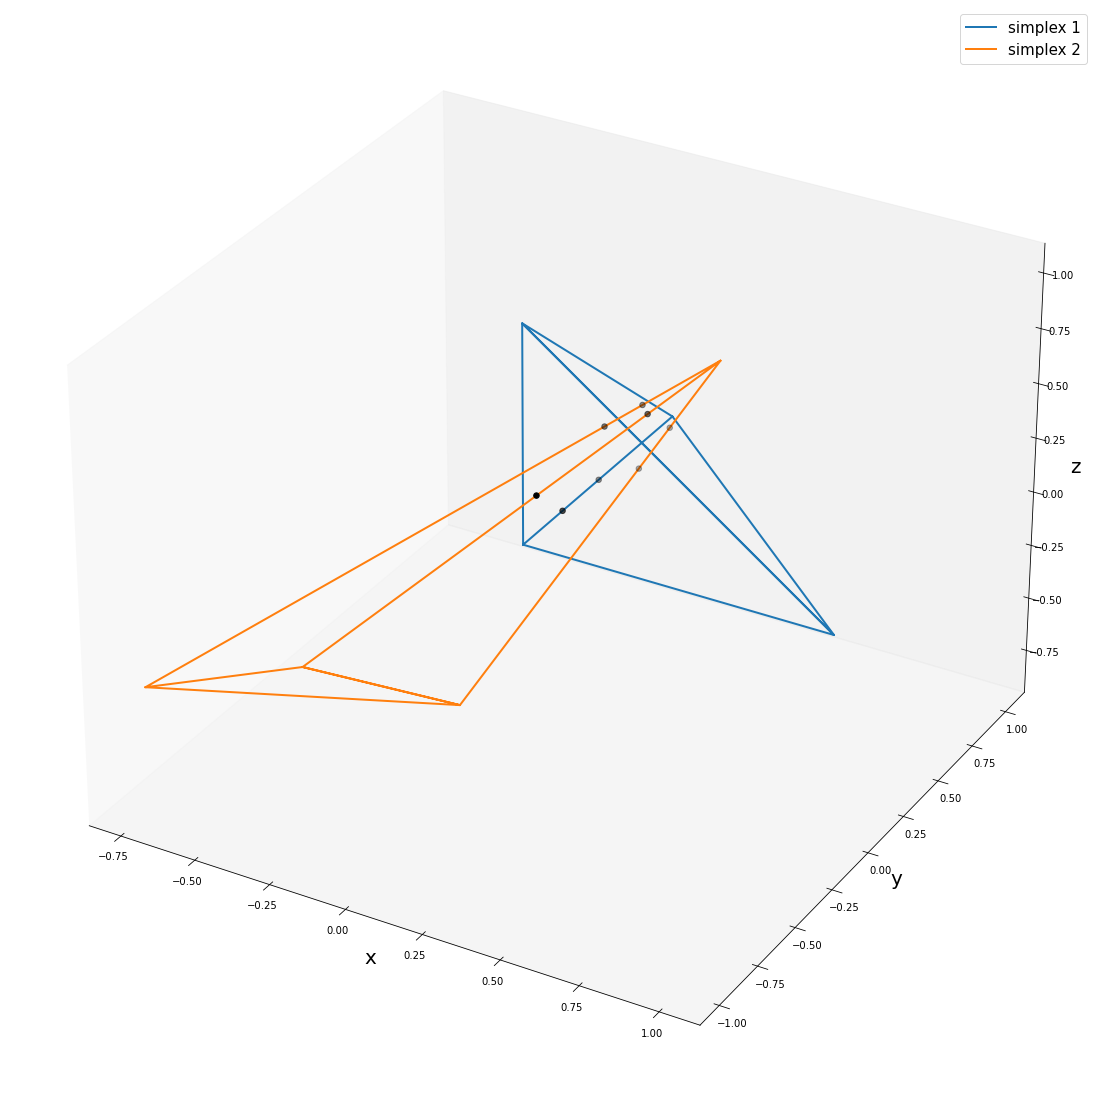

In [42]:
Order = np.array([0,3,1,0,2,3,1,2]).astype(int)

fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(111,projection = '3d')

points = vertices1[Order,:]

ax.plot(points[:,0] , points[:,1] , points[:,2],linewidth=2)

points = vertices2[Order,:]

ax.plot(points[:,0] , points[:,1] , points[:,2],linewidth=2)

if intersect_points.size != 0: 
    ax.scatter(intersect_points[:,0] , intersect_points[:,1] , intersect_points[:,2], c = 'black',s = 30)

ax.set_xlabel('x',fontsize=20)
ax.set_ylabel('y',fontsize=20)
ax.set_zlabel('z',fontsize=20)
ax.legend(['simplex 1','simplex 2'], fontsize=15)
ax.grid(False)

plt.show()

---
## Check accuracy of intersecting volume computation

* The accuracy in the volume computation will be tested as follows:
    * Randomly generate a simplex that lies inside the unit cube, say $S$.
    * Compute its exact volume, that is:
        * If the simplex $S$ is generated by the vertices $p_0,p_1,p_2,p_3$, then its volume is 
        
        $$\nu(S) = \frac{1}{6}|(p_1-p_0)\cdot (p_2-p_0)\wedge (p_3-p_0)|$$
        
        where "$\wedge$" denotes the wedge-product between vectors and "$\cdot$", the scalar product. 
                                      
* Compute the volume of the intersection between the generated simplex $S$ and every simplex in the triangulation of the cube. 
* Add all these volumes. Call this quantity $\nu_{num}(S)$.
* It should hold that 

 $$ \nu(S) = \nu_{num}(S)$$
 
In practice we will consider the relative error, that is:

$$\frac{|\nu(S)-\nu_{num}(S)|}{\nu(S)}$$

In [44]:
from tqdm import tqdm 

d = 3

triang_cube = cube_triangulation(d)

mismatch = []

T = 100
for t in tqdm(range(T)): 
    simplex = np.random.random((d+1,d)) 
    exact_vol = np.abs(lg.det(simplex[1:]-simplex[0])) 
    num_vol = 0
    for simplex2 in triang_cube:
        delta_vol, _ = simplex_intersection((simplex,simplex2)) 
        num_vol = num_vol + delta_vol 
    if exact_vol < 10**(-10):
        mismatch.append(np.abs(num_vol-exact_vol)) 
    else:
        mismatch.append(np.abs(num_vol-exact_vol)/exact_vol)

print('Maximum relative volume error:')
print("|exact_vol-num_vol|/exact_vol = {}".format(np.max(mismatch)))

100%|██████████| 100/100 [00:14<00:00,  7.14it/s]

Maximum relative volume error:
|exact_vol-num_vol|/exact_vol = 1.2221677243233575e-14
